In [72]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Overview thresholds different datasets
1) fema: Admin2 boundaries FewsNet (Eleonere's analysis) - Fewsnet-->Admin2 IPC by IPC value of max area  
2) unma: Admin2 boundaries UN population data - Fewsnet-->Admin2 IPC by IPC value of max area  
3) unim: Admin2 boundaries UN population data - Fewsnet-->Admin2 IPC by max IPC value  

In [36]:
df_dict={}

In [39]:
df_fe=pd.read_csv("Data/ethiopia_admin1_fewsnet_population_oldshp.csv",index_col=0)
df_fe.rename(columns={"ADMIN1":"ADM1_EN","ADMIN2":"ADM2_EN"},inplace=True)
df_dict["fema"]={"df":df_fe}

In [37]:
df_dict["unma"]={"df":pd.read_csv("Data/ethiopia_admin1_fewsnet_population_test.csv",index_col=0)}

In [38]:
df_dict["unim"]={"df":pd.read_csv("Data/ethiopia_admin1_fewsnet_population_2019maxCS.csv",index_col=0)}

In [61]:
def get_trigger(row, status, level, perc):
    # range till 6 cause 5 is max level
    cols = [f"{status}_{l}" for l in range(level, 6)]
    if np.isnan(row[f"pop_{status}"]) or row[f"pop_{status}"]==0:
        return np.nan
    if row[cols].sum() >= row[f"pop_{status}"] / (100 / perc):
        return 1
    else:
        return 0


def get_trigger_increase(row, level, perc):
    # range till 6 cause 5 is max level
    cols_ml1 = [f"ML1_{l}" for l in range(level, 6)]
    cols_cs = [f"CS_{l}" for l in range(level, 6)]
    if row[["pop_CS", "pop_ML1"]].isnull().values.any():
        return np.nan
    if row[cols_ml1].sum() == 0:
        return 0
    if row[cols_ml1].sum() >= row[cols_cs].sum() * (1 + (perc / 100)):
        return 1
    else:
        return 0

In [62]:
for k in df_dict.keys():
    df=df_dict[k]["df"]
    df["date"]=pd.to_datetime(df["date"])
    df["year"]=df["date"].dt.year
    df["month"]=df["date"].dt.month
    df["trigger_CS_3_20"]=df.apply(lambda x: get_trigger(x,"CS",3,20),axis=1)
    df["trigger_CS_4_2"]=df.apply(lambda x: get_trigger(x,"CS",4,2.5),axis=1)
    df["trigger_CS_4_20"]=df.apply(lambda x: get_trigger(x,"CS",4,20),axis=1)
    df["trigger_CS_4_1"]=df.apply(lambda x: get_trigger(x,"CS",4,0.1),axis=1)
    df["trigger_ML1_3_5"]=df.apply(lambda x: get_trigger(x,"ML1",3,5),axis=1)
    df["trigger_ML1_4_2"]=df.apply(lambda x: get_trigger(x,"ML1",4,2.5),axis=1)
    df["trigger_ML1_3_30"]=df.apply(lambda x: get_trigger(x,"ML1",3,30),axis=1)
    df["trigger_ML1_3_5i"]=df.apply(lambda x: get_trigger_increase(x,3,5),axis=1)
    for c in ["CS_3","CS_4","ML1_3","ML1_4"]:
        status=c.split("_")[0]
        df[f"perc_{c}"]=df[c]/df[f"pop_{status}"]*100
    df_dict[k]["df"]=df

In [63]:
for k in df_dict.keys():
    print(k)
    df=df_dict[k]["df"]
    #Analysis: IPC4+ at 20% (current situation)
    df_snCS420 = df.loc[df['trigger_CS_4_20']==1]
    display(df_snCS420.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x)))
    df_dict[k]["an4_20"]=df_snCS420

unma


,year,month,ADM1_EN
0,2009,7,[Somali]
1,2009,10,[Somali]
2,2011,4,[Somali]
3,2011,7,[Somali]
4,2011,10,[Somali]
5,2017,6,[Somali]
6,2017,10,[Somali]


unim


,year,month,ADM1_EN
0,2009,7,"[Gambela, Somali]"
1,2009,10,"[Gambela, Somali]"
2,2010,1,[Somali]
3,2010,4,"[Amhara, Gambela, Harari, Oromia, Somali, Tigray]"
4,2010,7,[Gambela]
5,2010,10,[Somali]
6,2011,1,[Somali]
7,2011,4,[Somali]
8,2011,7,"[Oromia, Somali]"
9,2011,10,"[Oromia, Somali]"


fema


,year,month,ADM1_EN
0,2009,7,[Somali]
1,2009,10,[Somali]
2,2011,4,[Somali]
3,2011,7,[Somali]
4,2011,10,[Somali]
5,2016,2,[Oromia]
6,2017,6,[Somali]


In [75]:
def col_pop(row,col,df):
    pop_col=df[df.date==row.date][col].sum()
    return pop_col

def col_perc(row,col,df):
    s=col.split("_")[0]
    return df[df.date==row.date][col].sum()/df[df.date==row.date][f"pop_{s}"].sum()*100

In [79]:
for k in df_dict.keys():
    print(k)
    df=df_dict[k]["an4_20"]
    an_group=df.groupby(["date","year"],as_index=False)["ADM1_EN"].agg(lambda x:list(x))
    for i in ["CS_4"]:
        an_group[f"perc_{i}_reg"]=an_group.apply(lambda x: col_perc(x,i,df),axis=1)
        an_group[f"{i}_reg"]=an_group.apply(lambda x: col_pop(x,i,df),axis=1)
        an_group[f"perc_{i}_tot"]=an_group.apply(lambda x: col_perc(x,i,df_dict[k]["df"]),axis=1)
        an_group[f"{i}_tot"]=an_group.apply(lambda x: col_pop(x,i,df_dict[k]["df"]),axis=1)
        an_group["pop_reg"]=an_group.apply(lambda x: col_pop(x,"adjusted_population",df),axis=1)
#     dict_an["an3"]["df_group"]=an_group
    display(an_group)

unma


,date,year,ADM1_EN,perc_CS_4_reg,CS_4_reg,perc_CS_4_tot,CS_4_tot,pop_reg
0,2009-07-01,2009,[Somali],43.631949,2062686.0,2.833951,2062686.0,4727467
1,2009-10-01,2009,[Somali],62.292534,2944859.0,4.045979,2944859.0,4727467
2,2011-04-01,2011,[Somali],43.631971,2181414.0,2.841672,2181414.0,4999577
3,2011-07-01,2011,[Somali],40.672921,2033474.0,5.197956,3990219.0,4999577
4,2011-10-01,2011,[Somali],40.672921,2033474.0,6.212739,4743790.0,4999577
5,2017-06-01,2017,[Somali],35.931005,2120446.0,2.249489,2120446.0,5901438
6,2017-10-01,2017,[Somali],25.397149,1498797.0,1.590009,1498797.0,5901438


unim


,date,year,ADM1_EN,perc_CS_4_reg,CS_4_reg,perc_CS_4_tot,CS_4_tot,pop_reg
0,2009-07-01,2009,"[Gambela, Somali]",73.972943,3757412.0,11.952145,9025261.0,5079441
1,2009-10-01,2009,"[Gambela, Somali]",88.380572,4489239.0,12.921303,9757088.0,5079441
2,2010-01-01,2010,[Somali],35.925416,1746305.0,2.249140,1746305.0,4860918
3,2010-04-01,2010,"[Amhara, Gambela, Harari, Oromia, Somali, Tigray]",33.818791,19021574.0,24.782040,19241581.0,56245577
4,2010-07-01,2010,[Gambela],71.506728,258790.0,0.988522,765047.0,361910
5,2010-10-01,2010,[Somali],35.925416,1746305.0,2.256411,1746305.0,4860918
6,2011-01-01,2011,[Somali],35.925419,1796119.0,2.249140,1796119.0,4999577
7,2011-04-01,2011,[Somali],82.283281,4113816.0,10.818758,8639649.0,4999577
8,2011-07-01,2011,"[Oromia, Somali]",53.413657,18927257.0,24.724999,19744902.0,35435239
9,2011-10-01,2011,"[Oromia, Somali]",46.902190,16619903.0,21.906275,17437548.0,35435239


fema


,date,year,ADM1_EN,perc_CS_4_reg,CS_4_reg,perc_CS_4_tot,CS_4_tot,pop_reg
0,2009-07-01,2009,[Somali],44.504032,1858192.0,3.177031,1858192.0,4175334.0
1,2009-10-01,2009,[Somali],56.430863,2356177.0,4.028458,2356177.0,4175334.0
2,2011-04-01,2011,[Somali],44.504053,1965149.0,3.187810,1965149.0,4415663.0
3,2011-07-01,2011,[Somali],42.029045,1855861.0,6.184703,3812606.0,4415663.0
4,2011-10-01,2011,[Somali],42.029045,1855861.0,5.509613,3373891.0,4415663.0
5,2016-02-01,2016,[Oromia],20.119602,5831480.0,8.986992,6687060.0,28984073.0
6,2017-06-01,2017,[Somali],29.006039,1511851.0,1.978431,1511851.0,5212194.0


In [69]:
def plot_aff_dates(df_d,df_trig,col,shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp",title=None):
    
    num_dates=len(df_trig.date.unique())
#     print(num_dates)
    colp_num=2
    rows=num_dates // colp_num
    rows+=num_dates % colp_num
    position = range(1, num_dates + 1)

    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["ADM1_EN","geometry"]].merge(df_d,on="ADM1_EN",how="left")
    colors = len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks"#'equalinterval'
    fig = plt.figure(1,figsize=(16,6*rows))
    
    for i,c in enumerate(df_trig.date.unique()):
#         print(i)
#         print(df_geo[df_geo.date==c])
        ax = fig.add_subplot(rows,colp_num,position[i])
#         print(i)
#         print(df_geo[df_geo.date==c])
        df_date=df_geo[df_geo.date==c]
        if df_date[col].isnull().values.all():
            print(f"No not-NaN values for {c}")
        elif df_date[col].isnull().values.any():
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme,missing_kwds={"color": "lightgrey", "edgecolor": "red",
   "hatch": "///",
    "label": "Missing values"})#, classification_kwds=dict(bins=bins)) #scheme="UserDefined"
        else:
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme)
#    "edgecolor": "red",
#    "hatch": "///",
#     "label": "Missing values",
#   }) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
        gdf.boundary.plot(linewidth=0.2,ax=ax)

        ax.axis("off")
        
        plt.title(pd.DatetimeIndex([c])[0].to_period('M'))
        if not df_date[col].isnull().values.all():
            leg = ax.get_legend()

            for lbl in leg.get_texts():
                label_text = lbl.get_text()
#                 print(label_text)
                upper = label_text.split(",")[-1].rstrip(']')

    #             print("f",upper)
                try:
                    new_text = f'{float(upper):,.2f}'
                except:
                    new_text=upper
                lbl.set_text(new_text)

    if title:
        fig.suptitle(title,fontsize=14)
    fig.tight_layout()#show()
    plt.show()

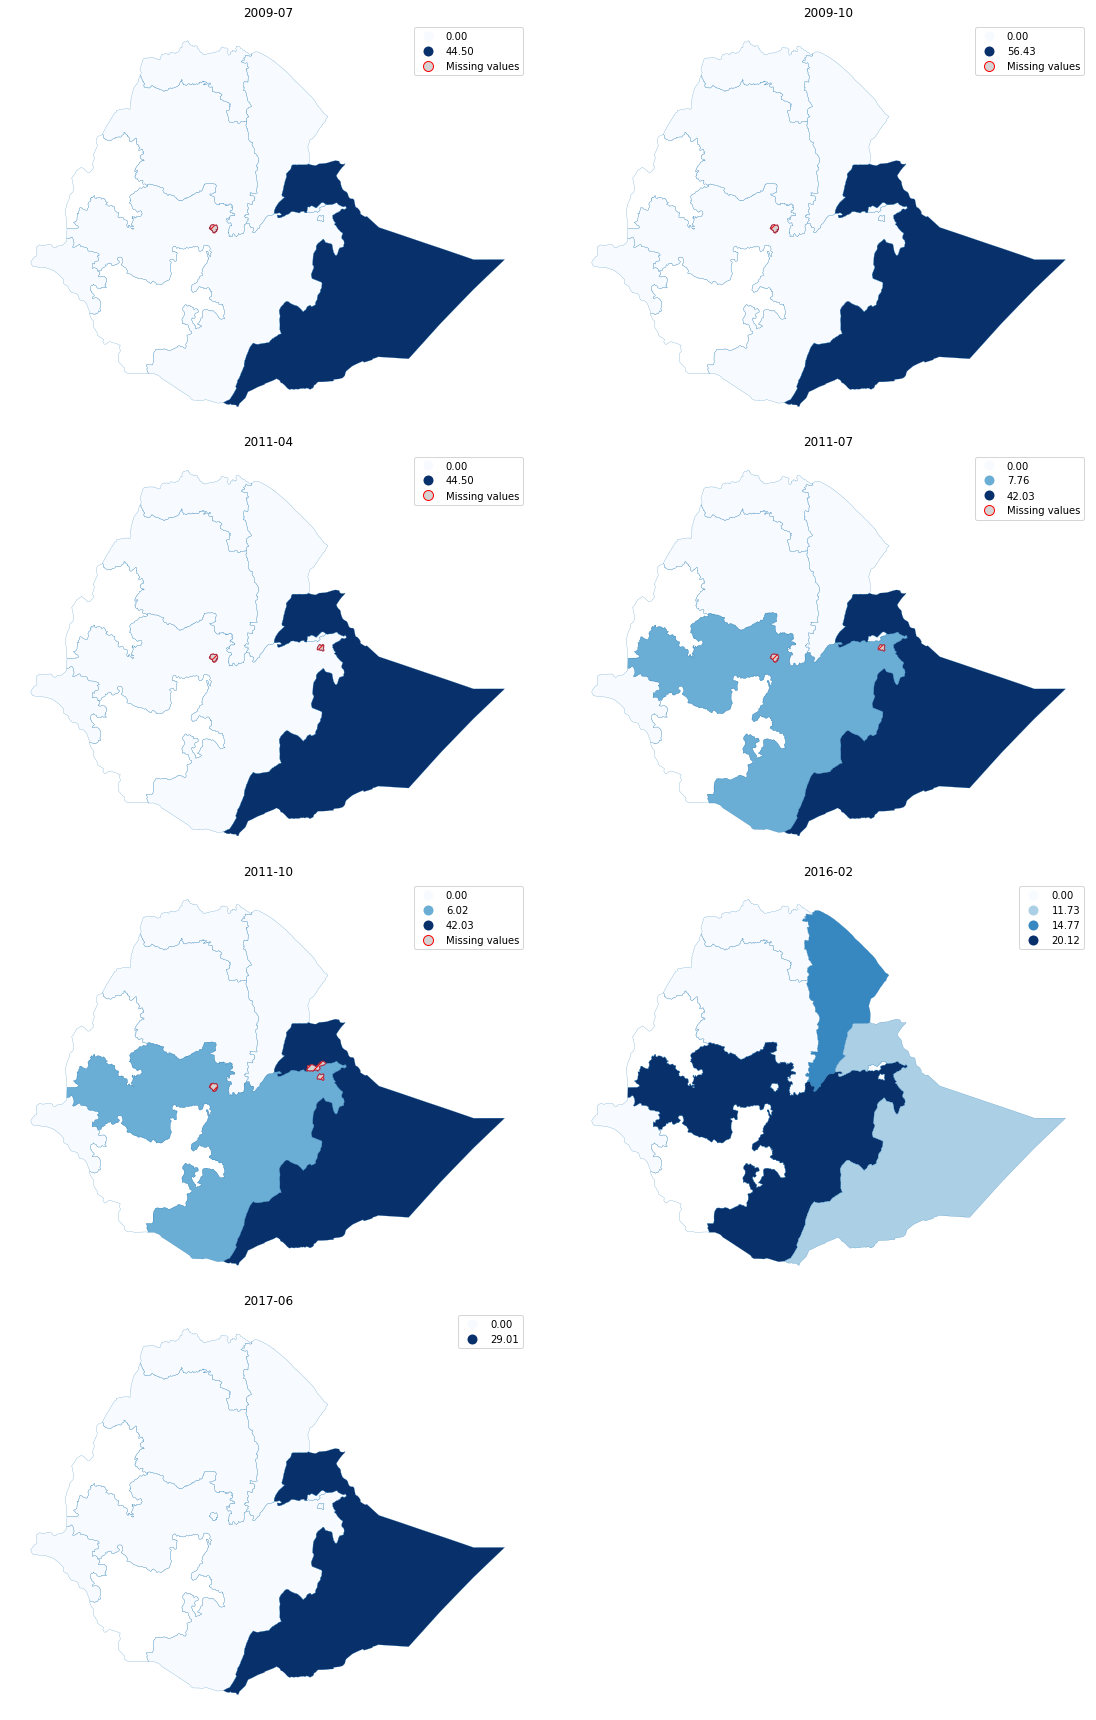

In [74]:
plot_aff_dates(df_dict["fema"]["df"],df_dict["fema"]["an4_20"],"perc_CS_4")#,shape_path="Data/ET_Admin2_2014/ET_Admin2_2014.shp")

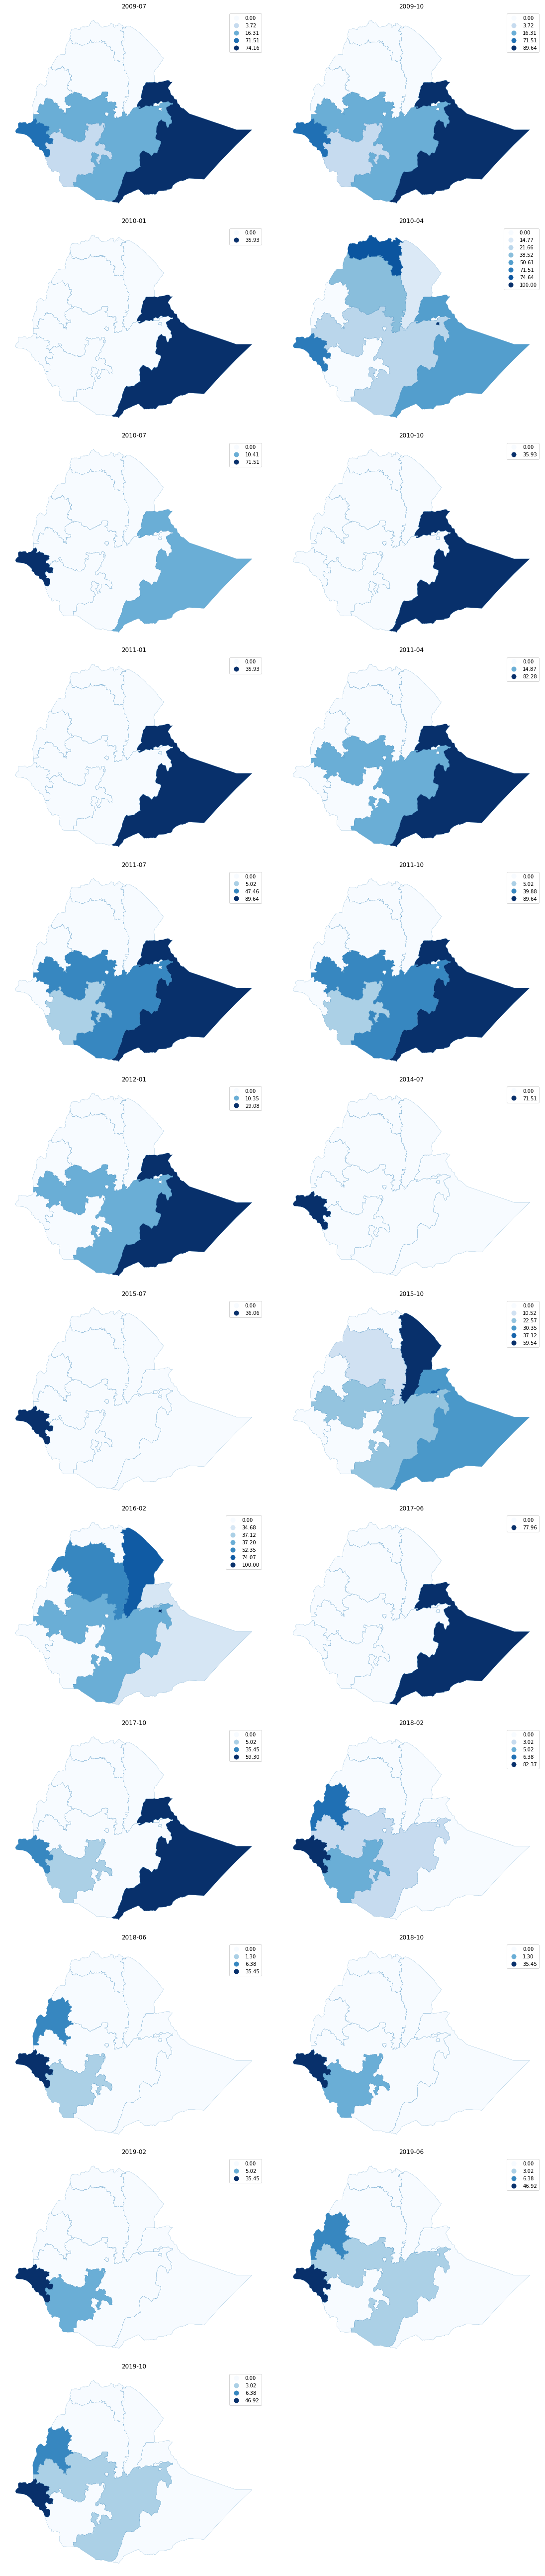

In [73]:
plot_aff_dates(df_dict["unim"]["df"],df_dict["unim"]["an4_20"],"perc_CS_4")#,shape_path="Data/ET_Admin2_2014/ET_Admin2_2014.shp")